In [1]:
import heapq, random, itertools, operator, functools, math
import matplotlib.pyplot as plt
from sympy import IndexedBase

In [2]:
def take(iterable, n):
    for _ in range(n):
        yield next(iterable)

In [3]:
a = IndexedBase('a')
actions = [a[i] for i in range(10)]
actions

[a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9]]

In [4]:
q_star = { a: random.gauss(0, 1) for a in actions }

In [5]:
def rewarder(q_star, process, *, stationarity):
    
    reward = None
    Q = {a: v for a, v in q_star.items()}
    
    while True:
        
        action, q, n, t, by = process.send(reward)
        qs = Q[action]
        reward = random.gauss(qs, 1)
        yield action, q, qs, by, reward
        
        Q = {a:stationarity(a, q) for a, q in Q.items()}

In [20]:
def k_armed_bandit(actions, epsilon, init=lambda action: 0, *, update,measure):
    
    Q = [(-q, -q, 0, i, a) for i, a in enumerate(actions) for q in [init(a)]]
    heapq.heapify(Q)
    
    for t in itertools.count():

        by = None
        if random.random() > epsilon:
            _, q, n, i, a = heapq.heappop(Q)
            by = 'e' # exploiting flag
        else:
            j = random.randrange(0, len(Q))
            _, q, n, i, a = Q.pop(j)
            heapq.heapify(Q) # takes linear time to maintain the heap invariant.
            by = 's' # search flag
        
        q = -q # to restore "max-heap" behavior
        n_next = n + 1
        tup = (a, q, n_next, t, by)
        reward = yield tup
        
        q_updated = update(*(tup + (reward,)))
        
        q_measured = measure(a, q_updated, n_next, t, by, reward)
        
        heapq.heappush(Q, (-q_measured, -q_updated, n_next, i, a))

In [9]:
def optimistic_k_armed_bandit(init):
    return functools.partial(k_armed_bandit, init=init, measure=lambda *args: args[1])

In [10]:
def sample_average(action, q, n, t, by, reward):
    return q + ((reward - q)/n)

In [11]:
def exponential_recency_weighted_average(alpha):
    return lambda action, q, n, t, by, reward: q + alpha*(reward - q)

In [12]:
def upper_confidence_bound(c):
    def M(action, q, n, t, by, reward):
        #return q if by == 's' else (q + c * math.sqrt(math.log(t+1)/n))
        return q + c * math.sqrt(math.log(t+1)/n)
    return functools.partial(k_armed_bandit, measure=M)


In [13]:
def unbiased_exponential_recency_weighted_average(alpha):
    o = 0.0
    
    def unbiased(action, q, n, t, by, reward): 
        nonlocal o
        o = o + alpha*(1-o)
        step_size = alpha / o
        return q + step_size*(reward-q)
    
    return unbiased

In [14]:
def stationary(a, q):
    return q

In [15]:
def gauss_error_non_stationary(sd):
    return lambda a, q: q + random.gauss(0, sd)

In [16]:
def avg(*args):
    return sum(args)/len(args)

In [146]:
R = rewarder(q_star, 
             process=k_armed_bandit(actions, epsilon=0.1, update=sample_average), 
             stationarity=stationary)

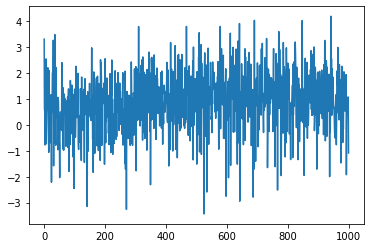

In [147]:
plt.plot(list(take(map(lambda tup: tup[-1], R), 1000)));

In [194]:
R = rewarder(q_star, 
             process=optimistic_k_armed_bandit(actions, epsilon=0.1, update=sample_average), 
             stationarity=stationary)

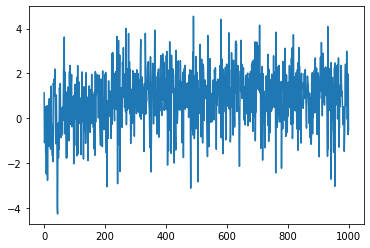

In [195]:
plt.plot(list(take(map(lambda tup: tup[-1], R), 1000)));

In [186]:
list(take(R, 100))

[(a[6], 1.1603025623309136, 1.193593242594897, 'e', 2.025184908199433),
 (a[6], 1.1612809360253349, 1.193593242594897, 'e', -0.21065852210900782),
 (a[6], 1.159730721948347, 1.193593242594897, 'e', 0.675522184564056),
 (a[6], 1.1591842111838049, 1.193593242594897, 'e', 0.8977523121521089),
 (a[6], 1.158889473980838, 1.193593242594897, 'e', 1.9767313536305577),
 (a[6], 1.1598104670885516, 1.193593242594897, 'e', 1.766221427556978),
 (a[6], 1.1604925941531956, 1.193593242594897, 'e', 0.34780046938366393),
 (a[6], 1.1595794569343534, 1.193593242594897, 'e', 1.672830331969025),
 (a[6], 1.1601554960758065, 1.193593242594897, 'e', 1.569281577967653),
 (a[6], 1.160614157602591, 1.193593242594897, 'e', 1.8530315605901768),
 (a[6], 1.1613895410325883, 1.193593242594897, 'e', 1.7222081976080654),
 (a[6], 1.1620168549661178, 1.193593242594897, 'e', -0.193119465329463),
 (a[9], -0.615337335996176, -0.9771139250377112, 's', 0.8023605771727995),
 (a[6], 1.1605027361724916, 1.193593242594897, 'e', 2.

In [148]:
R = rewarder(q_star,
             process=k_armed_bandit(actions, 
                                    epsilon=0.1, 
                                    update=exponential_recency_weighted_average(alpha=0.1)),
             stationarity=gauss_error_non_stationary(sd=0.01))

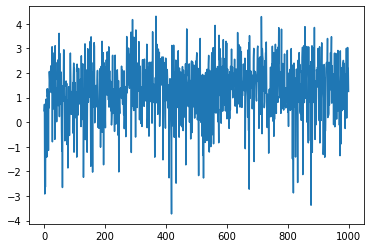

In [149]:
plt.plot(list(take(map(lambda tup: tup[-1], R), 1000)));

In [150]:
R = rewarder(q_star,
             process=k_armed_bandit(actions, 
                                    epsilon=0.1, 
                                    update=unbiased_exponential_recency_weighted_average(alpha=0.1)),
             stationarity=gauss_error_non_stationary(sd=0.01))

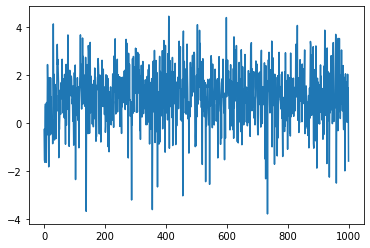

In [151]:
plt.plot(list(take(map(lambda tup: tup[-1], R), 1000)));

In [18]:
def benchmark(confs, nprocesses=2000, length=10000, filename=None):
    plt.ylim(-0.5, 2)
    avgs = []
    for conf in confs:
        process = conf['process']
        runs = [map(lambda tup: tup[-1], 
                    rewarder(q_star, 
                             process= process(actions, 
                                              epsilon=conf['epsilon'], 
                                              update=conf['update']),
                             stationarity=conf['stationarity'])) 
                for i in range(nprocesses)]
        R = list(take(map(avg, *runs), length))
        avgs.append(R)
        plt.plot(R, label=conf['label'])
    
    ret = plt.legend()
    
    if filename: 
        plt.savefig(filename)
        
    return ret, avgs

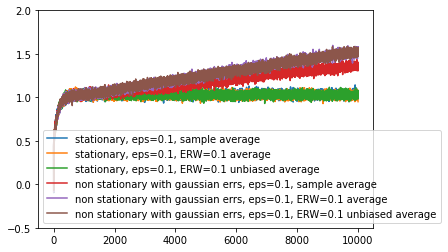

In [155]:
confs = [
    {
        'epsilon':0.1, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'stationary, eps=0.1, sample average'
    },
    {
        'epsilon':0.1, 
        'update':exponential_recency_weighted_average(alpha=0.1), 
        'stationarity':stationary, 
        'label': 'stationary, eps=0.1, ERW=0.1 average'
    },
    {
        'epsilon':0.1, 
        'update':unbiased_exponential_recency_weighted_average(alpha=0.1), 
        'stationarity':stationary, 
        'label': 'stationary, eps=0.1, ERW=0.1 unbiased average'
    },
    {
        'epsilon':0.1, 
        'update':sample_average, 
        'stationarity':gauss_error_non_stationary(sd=0.01), 
        'label': 'non stationary with gaussian errs, eps=0.1, sample average'
    },
    {
        'epsilon':0.1, 
        'update':exponential_recency_weighted_average(alpha=0.1), 
        'stationarity':gauss_error_non_stationary(sd=0.01), 
        'label': 'non stationary with gaussian errs, eps=0.1, ERW=0.1 average'
    },
    {
        'epsilon':0.1, 
        'update':unbiased_exponential_recency_weighted_average(alpha=0.1), 
        'stationarity':gauss_error_non_stationary(sd=0.01), 
        'label': 'non stationary with gaussian errs, eps=0.1, ERW=0.1 unbiased average'
    },
]
# bench
fig, avgs = benchmark(confs, filename='non-stationary-benchmark.svg', length=10_000)
fig

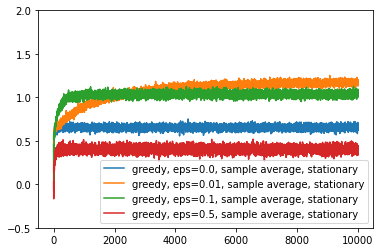

In [156]:
confs = [
    {
        'epsilon':0, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy, eps=0.0, sample average, stationary'
    },
    {
        'epsilon':0.01, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy, eps=0.01, sample average, stationary'
    },
    {
        'epsilon':0.1, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy, eps=0.1, sample average, stationary'
    },
    {
        'epsilon':0.5, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy, eps=0.5, sample average, stationary'
    },
]

# bench
fig, avgs = benchmark(confs, filename='stationary-benchmark.svg', length=10_000)
fig;

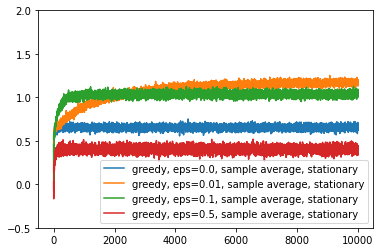

In [156]:
confs = [
    {
        'epsilon':0, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy, eps=0.0, sample average, stationary'
    },
    {
        'epsilon':0.01, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy, eps=0.01, sample average, stationary'
    },
    {
        'epsilon':0.1, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy, eps=0.1, sample average, stationary'
    },
    {
        'epsilon':0.5, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy, eps=0.5, sample average, stationary'
    },
]

# bench
fig, avgs = benchmark(confs, filename='stationary-benchmark.svg', length=10_000)
fig;

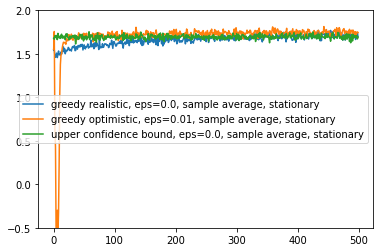

In [28]:
confs = [
    {
        'process': functools.partial(k_armed_bandit, measure=lambda *args: args[1]),
        'epsilon':0.1, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy realistic, eps=0.0, sample average, stationary'
    },
    {
        'process': optimistic_k_armed_bandit(init=lambda action: 100),
        'epsilon':0.1, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'greedy optimistic, eps=0.01, sample average, stationary'
    },
    {
        'process': upper_confidence_bound(c=2),
        'epsilon':0, 
        'update':sample_average, 
        'stationarity':stationary, 
        'label': 'upper confidence bound, eps=0.0, sample average, stationary'
    },
]

# bench
fig, avgs = benchmark(confs, filename='stationary-benchmark.svg', nprocesses=2000, length=500)
fig;